In [1]:
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline 

In [2]:
# connect to postgres db on vb

try:
    conn = psycopg2.connect(database='vagrant', user='eruser', password = 'emergency', host='localhost', port='5432')
    print("Opened database successfully")
    
except psycopg2.Error as e:
    print("I am unable to connect to the database")
    print(e)
    print(e.pgcode)
    print(e.pgerror)
    print(traceback.format_exc())

Opened database successfully


In [3]:
'''
query psql to pull number of crimes by census track by week from 2012 - 2016
inserts query result in pandas df called df2
'''

cur = conn.cursor()
QUERY='''SELECT census_tract, date_trunc('week', occ_date) AS week, count(*) AS num
    FROM crimes
    GROUP BY week, census_tract
    ORDER BY week, census_tract;'''

try:
    print("SQL QUERY = "+QUERY)
    cur.execute(QUERY)

except Exception as e:
    print(e.pgerror)
    
# Extract the column names and insert them in header
col_names = []
for elt in cur.description:
    col_names.append(elt[0])    
    
D = cur.fetchall() #convert query result to list
#pprint(D)
df = pd.DataFrame(D) #convert to pandas df
#conn.close()
df.head() # print the df head


# Create the dataframe, passing in the list of col_names extracted from the description
df2 = pd.DataFrame(D, columns=col_names)
df2.head()

SQL QUERY = SELECT census_tract, date_trunc('week', occ_date) AS week, count(*) AS num
    FROM crimes
    GROUP BY week, census_tract
    ORDER BY week, census_tract;


,census_tract,week,num
0,100.0,2012-02-27 00:00:00+00:00,13
1,200.0,2012-02-27 00:00:00+00:00,12
2,301.0,2012-02-27 00:00:00+00:00,8
3,302.0,2012-02-27 00:00:00+00:00,1
4,401.0,2012-02-27 00:00:00+00:00,10


In [4]:
#conn.close()

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37559 entries, 0 to 37558
Data columns (total 3 columns):
census_tract    37310 non-null float64
week            37559 non-null datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)]
num             37559 non-null int64
dtypes: datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)](1), float64(1), int64(1)
memory usage: 880.4 KB


In [6]:
# look at number of crimes by census track
grouped_by_ct = df2.groupby('census_tract')['num'].sum().reset_index() # total crimes by census tract, resets index
grouped_by_ct.sort_values('num', ascending=False)[:25] # sort by num descending, show top 25

,census_tract,num
168,10600.0,42243
80,5100.0,33976
117,8100.0,20417
129,9000.0,15897
35,2303.0,15784
120,8301.0,14877
33,2100.0,14727
119,8202.0,14648
17,1101.0,14334
37,2402.0,12184


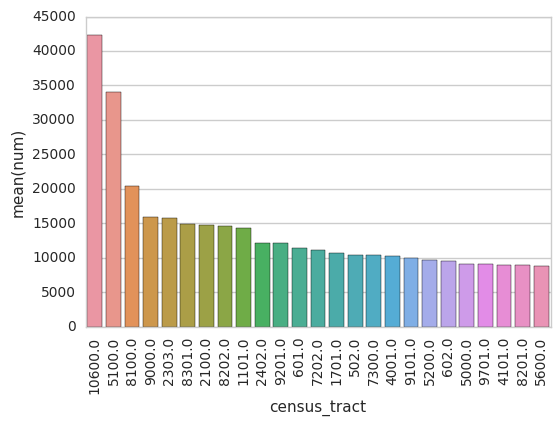

In [7]:
# barchart of top 25 census tracks with highest total crime
top_25 = grouped_by_ct.sort_values('num', ascending=False)[:25]
sns.set_style("whitegrid")
top_25_barplot = sns.barplot(x= top_25['census_tract'],y = top_25['num'], order = top_25['census_tract'], )
for item in top_25_barplot.get_xticklabels():
    item.set_rotation(90) # rotates x axis labels

Census tracts 10600, 5100, and 8100 have significantly higher total number of crimes from 2012-November 2016.

In [8]:
# some summary stats
print('median crimes/tract = '+str(grouped_by_ct['num'].median()))
grouped_by_ct.describe()


median crimes/tract = 2533.0


,census_tract,num
count,235.000000,235.000000
mean,16060.055319,3650.965957
std,64148.953564,5020.966842
min,100.000000,1.000000
25%,3602.500000,5.000000
50%,8100.000000,2533.000000
75%,21050.000000,5517.500000
max,980000.000000,42243.000000


In [9]:
# let's look at census tract 10600 in greater detail

df2[df2['census_tract'] == 10600.0].head()

,census_tract,week,num
141,10600.0,2012-02-27 00:00:00+00:00,79
291,10600.0,2012-03-05 00:00:00+00:00,153
441,10600.0,2012-03-12 00:00:00+00:00,166
591,10600.0,2012-03-19 00:00:00+00:00,122
740,10600.0,2012-03-26 00:00:00+00:00,137


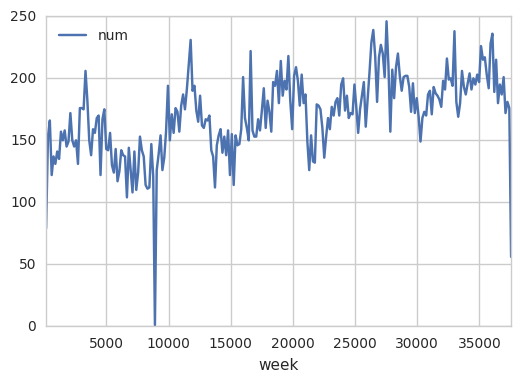

In [10]:
ct_by_week_1 = df2[df2['census_tract'] == 10600.0]
#ct_by_week_1_series = pd.Series(ct_by_week_1['num'], index = ct_by_week_1['week'])
plot1 = ct_by_week_1.loc[:,['week', 'num']].plot()
plot1.set_xlabel("week")

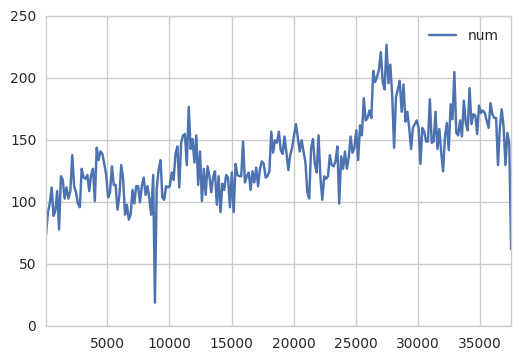

In [11]:
df2[df2['census_tract'] == 5100.0].loc[:,['week', 'num']].plot()

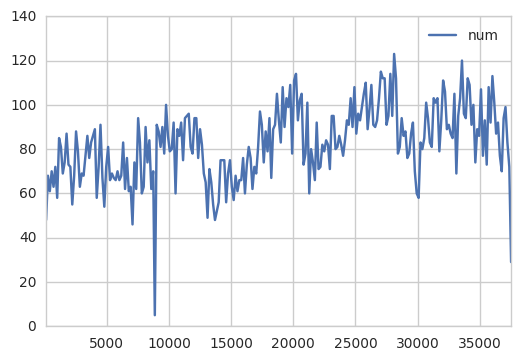

In [12]:
df2[df2['census_tract'] == 8100.0].loc[:,['week', 'num']].plot()

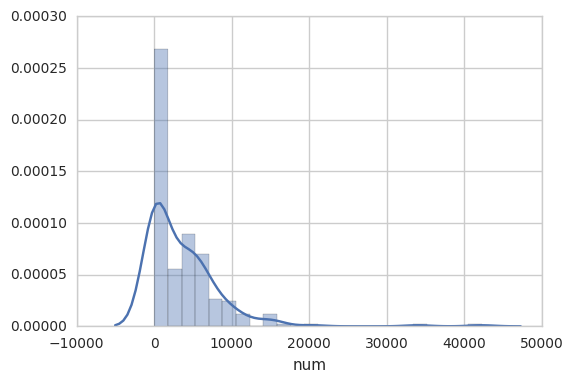

In [13]:
sns.distplot(grouped_by_ct['num'])

The mean is notably higher than the median which suggests a right skewed distribution with outliers on the high side.

In [14]:
# which census tracts have the lowest amount of crime?
grouped_by_ct.sort_values('num', ascending=False)[-75:] # sort by num descending, show top 25

,census_tract,num
186,22107.0,29
140,9604.0,28
206,30600.0,25
141,9605.0,20
145,9801.0,18
166,10410.0,18
204,30501.0,17
200,30200.0,16
188,22201.0,13
155,10100.0,8


In [15]:
low_75 = grouped_by_ct.sort_values('num', ascending=False)[-75:] 
n = sum([1 for x in low_75['num'] if x <= 3])

print('there are {} census tracts with 3 or fewer crimes'.format(n))

there are 51 census tracts with 3 or fewer crimes


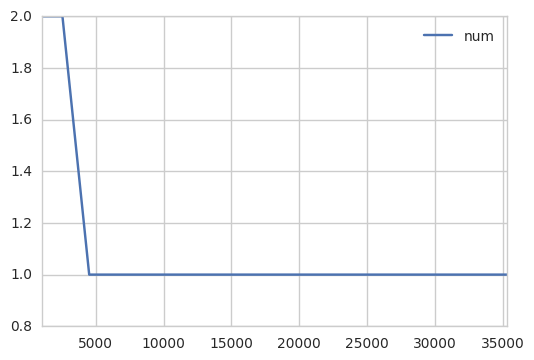

In [16]:
#let's visualize what weekly crime trends for one of those "few crime" tracts look like
df2[df2['census_tract'] == 22107.0].loc[:,['week', 'num']].plot()

/home/vagrant/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=6797.0, right=6797.0
  'left=%s, right=%s') % (left, right))


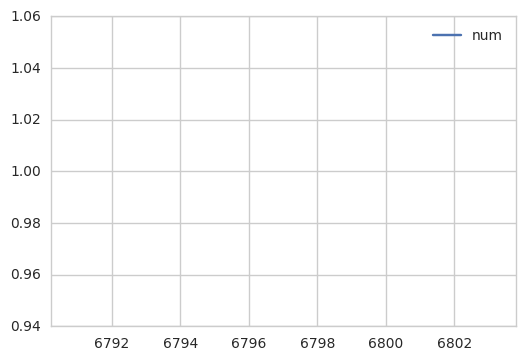

In [17]:
df2[df2['census_tract'] == 21500.0].loc[:,['week', 'num']].plot()

In [18]:
# how many types of crime in db?
cur = conn.cursor()
QUERY='''SELECT DISTINCT case_desc 
    FROM crimes
    ORDER BY case_desc;'''
    
try:
    print("SQL QUERY = "+QUERY)
    cur.execute(QUERY)

except Exception as e:
    print(e.pgerror)    

# Extract the column names and insert them in header
col_names = []
for elt in cur.description:
    col_names.append(elt[0])    
    
D = cur.fetchall() #convert query result to list
#pprint(D)

# Create the dataframe, passing in the list of col_names extracted from the description
df4 = pd.DataFrame(D, columns=col_names)
print(len(df4))
df4

SQL QUERY = SELECT DISTINCT case_desc 
    FROM crimes
    ORDER BY case_desc;
100


,case_desc
0,ACCIDENT - HIT AND RUN - COLD
1,ACCIDENT - HIT & RUN - PRIORITY
2,ACCIDENT - INJURY
3,ACCIDENT - NON INJURY
4,ACCIDENT - UNKNOWN INJURY
5,ANIMAL PROBLEM
6,ANIMAL PROBLEM - PRIORITY
7,AREA CHECK
8,ASSAULT - COLD
9,ASSAULT - PRIORITY


In [19]:
# try aggregating by crime type

'''
query psql to pull number of crimes by case_desc by week from 2012 - 2016
inserts query result in pandas df called df3
'''

cur = conn.cursor()
QUERY='''SELECT  case_desc, date_trunc('week', occ_date) AS week, count(*) AS num
    FROM crimes
    GROUP BY week, case_desc
    ORDER BY week, case_desc;'''


try:
    print("SQL QUERY = "+QUERY)
    cur.execute(QUERY)

except Exception as e:
    print(e.pgerror)
    
# Extract the column names and insert them in header
col_names = []
for elt in cur.description:
    col_names.append(elt[0])    
    
D = cur.fetchall() #convert query result to list
#pprint(D)

# Create the dataframe, passing in the list of col_names extracted from the description
df3 = pd.DataFrame(D, columns=col_names)
df3.head()

SQL QUERY = SELECT  case_desc, date_trunc('week', occ_date) AS week, count(*) AS num
    FROM crimes
    GROUP BY week, case_desc
    ORDER BY week, case_desc;


,case_desc,week,num
0,ACCIDENT - HIT AND RUN - COLD,2012-02-27 00:00:00+00:00,32
1,ACCIDENT - HIT & RUN - PRIORITY,2012-02-27 00:00:00+00:00,19
2,ACCIDENT - INJURY,2012-02-27 00:00:00+00:00,30
3,ACCIDENT - NON INJURY,2012-02-27 00:00:00+00:00,66
4,ACCIDENT - UNKNOWN INJURY,2012-02-27 00:00:00+00:00,12


In [20]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17036 entries, 0 to 17035
Data columns (total 3 columns):
case_desc    17036 non-null object
week         17036 non-null datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)]
num          17036 non-null int64
dtypes: datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)](1), int64(1), object(1)
memory usage: 399.4+ KB


In [21]:
# another way to look at the crime types
for i, crime in df3.iterrows():
    print(crime['case_desc'])
    if i == 50:
        break

ACCIDENT - HIT AND RUN - COLD              
ACCIDENT - HIT & RUN - PRIORITY            
ACCIDENT - INJURY                          
ACCIDENT - NON INJURY                      
ACCIDENT - UNKNOWN INJURY                  
ANIMAL PROBLEM                             
ANIMAL PROBLEM - PRIORITY                  
AREA CHECK                                 
ASSAULT - COLD                             
ASSAULT - PRIORITY                         
ASSAULT - WITH WEAPON *H                   
ASSIST - CITIZEN OR AGENCY                 
BOMB - DEVICE DISCOVERED (33B) *H          
BOMB - THREAT (33B)                        
BURGLARY - COLD                            
BURGLARY - PRIORITY *H                     
CIVIL - CIVIL PROBLEM                      
CIVIL - STANDBY                            
DELIVER MESSAGE                            
DETOX TRANSPORT                            
DISTURBANCE - COLD                         
DISTURBANCE - PRIORITY                     
DISTURBANCE - WITH WEAPON *H    

In [22]:
grouped_by_crime = df3.groupby('case_desc')['num'].sum().reset_index()     
#grouped_by_ct = df2.groupby('census_tract')['num'].sum().reset_index() # total crimes by census tract, resets index
top_25_crimes = grouped_by_crime.sort_values('num', ascending=False)[:25] # sort by num descending, show top 25  
grouped_by_crime.sort_values('num', ascending=False)[:25]

,case_desc,num
29,DISTURBANCE - PRIORITY,97361
87,UNWANTED PERSON,90922
74,"SUSPICIOUS SUBJ, VEH, OR CIRCUMSTANCE",55560
99,WELFARE CHECK - PRIORITY,55481
75,THEFT - COLD,51437
98,WELFARE CHECK - COLD,49273
44,HAZARD - HAZARDOUS CONDITION,28296
7,AREA CHECK,28106
50,NOISE DISTURBANCE,28099
11,ASSIST - CITIZEN OR AGENCY,28093


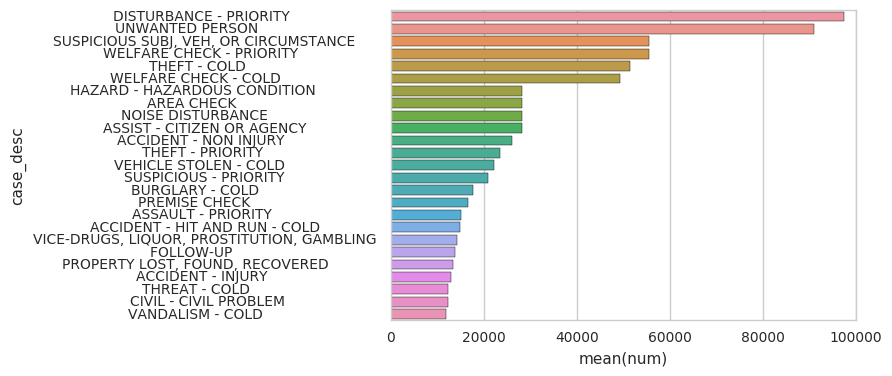

In [23]:
sns.set_style("whitegrid")
top_25_crimeplot= sns.barplot(y= top_25_crimes['case_desc'],x = top_25_crimes['num'], order = top_25_crimes['case_desc'])